In [1]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim import corpora
from textblob import TextBlob
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.sparse import save_npz, load_npz


In [2]:
#set seed so that code output is deterministic
random.seed(10)  # Set the seed for Python's random module
np.random.seed(10)  # Set the seed for NumPy's random module

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [4]:
data = data.drop(columns = ['index'])
data.head()

,text_type,ID,year,long_text,clean_text,word_count,tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]"
1,comment,gtfqkbv,2021,"That’s been there for several years, sent a pi...",years sent pic cuntry friend long time ago,8,"[year, send, pic, cuntry, friend, long, time, ..."
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]"


## **NGRAM MODEL** -->no stopword removal

In [18]:
#convert df['tokens'] to list of strings for CountVectorizer
corpus = data['tokens'].apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

['cuntry road hoem',
 'year send pic cuntry friend long time ago',
 'single travel cuntry past year',
 'happen shop dragon mart',
 'absolutely hilarious spring souk']

In [19]:
start_time = time.time() #track start time of execution

#instantiate CountVectorizer
ngram = CountVectorizer(ngram_range = (1,2))
   
#generate document vectors 
X_ngram = ngram.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The ngram representation had {X_ngram.shape[1]} features.")    

The program took 6.81 seconds to complete. The ngram representation had 811185 features.


In [7]:
#get feature names 
ngram_features = ngram.get_feature_names_out()


In [8]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
ngram_df = pd.DataFrame(X_ngram[8000:8005].toarray(), columns = ngram_features)

text_ngram = ngram_df.copy()
text_ngram = text_ngram.loc[:, (text_ngram == 1).any()] #show only columns with at least a 1 entry for any word

text_ngram.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_ngram

,clean_text,agent,agent rereading,asian,asian village,asset,asset price,aus fri,brodsky,brodsky comopolitan,...,village,village goody,visit,visit aus,want,want check,world,world trade,year,year want
0,dubai world trade center expo site rest taken ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,uni enjoyed felt brodsky comopolitan like town...,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,visit aus fri aus,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
3,kind intrigued feel reluctant time car maybe y...,0,0,1,1,0,0,0,0,0,...,1,1,0,0,1,1,0,0,1,1
4,real estate agent rereading sounds pro real es...,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


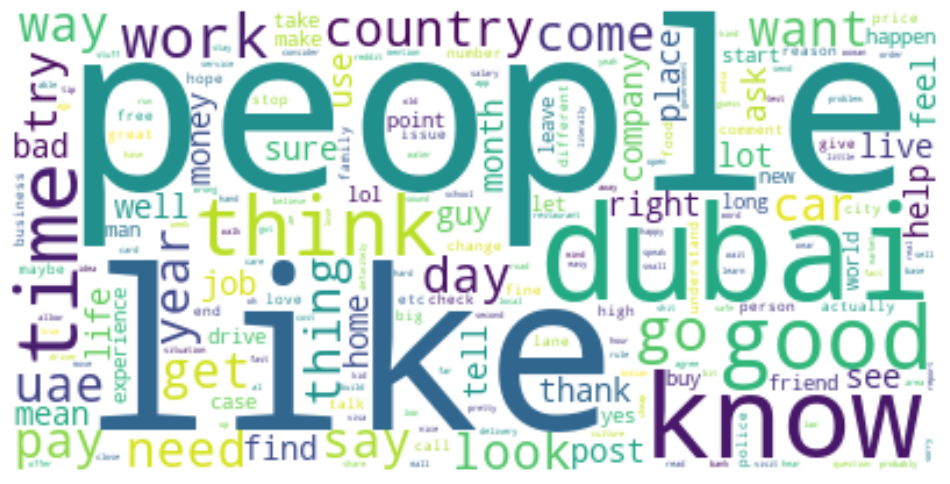

In [9]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(ngram_features, X_ngram.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

A look at the word cloud shows that the top commonly occuring words which need to be removed. It also shows the presence of informal words which add no information in our context, and as such should be removed as well. <br>We will redo the n-gram model, including these words as stopwords which will be disregarded by the model when creating the document vectors.

## **CREATE CUSTOM STOP WORDS LISTS**

In [17]:
common = [word for word, freq in word_scores_dict.items() if freq >=3000] #list of most common words
rare = [word for word, freq in word_scores_dict.items() if freq <=10] #list of rarely used words
other_words = [ #custom list of informal words carrying no meaning in our context
    "yeah", "okay", "ok", "lol", "omg", "brb", "btw", "imo", "imho", "ttyl", "idk", 
    "ikr", "smh", "np", "ty", "yw", "jk", "nvm", "tbh", "idc", "ily", "tmi", "wtf", 
    "wyd", "lmk", "atm", "fyi", "gtg", "g2g", "bff", "rofl", "stfu", "asap", 
    "post", "comment", "share", "like", "tweet", "follow", "update", "thread", 
    "dm", "pm", "status", "story", "tag", "meme", "emoji", "gif", "irl", "ama", 
    "tldr", "fomo", "yolo", "nsfw", "tbt", "q&a", "dms", "op", "subs", "mod", 
    "bot", "flair", "downvote", "upvote", "thread", "repost", "sidebar", "sticky", 
    "wiki", "karma", "gold", "throwaway", "username", "redditor", "crosspost", "redditor",
    "vote", "tl", "dr", "wow", "right", "sure", "definitely", "maybe", "know", "lately", 
    "probably", "r", "keep", "ae", "al", "kind", "oh", "wait", "stay", "shit", "old", "guess",
    "damn", "oh", "pretty", "hard", "reddit", "sub", "subreddit", "author", "previous", "got",
    "depend", "old", "nice", "cld", "pic", "bro", "shot", "photo", "oh", "question", "wish", "remember",
    "idea", "stuff", "fuck", "word", "second", "first", "third", "wrong", "easy", "week", "true",
    "believe", "literal", "literally", "haha", "hate", "move", "mind", "away", "yes", "big", 
    "problem", "happy", "high", "quality", "rate", "woman", "sorry", "happen", "feel", "guy", 
    "life", "try", "thank", "lot", "appreciate", "great", "help", "info", "information", "try",
    "bad", "feel", "world", "make", "lose", "love", "join", "place", "friend", "ask", "tell",
    "try", "live", "use", "hope", "soon", "let", "month", "talk", "help", "make", "different",
    "start", "issue", "mater", "hear", "leave", "actually", "person", "mention"
    "agree", "new", "though", "thought", "although", "send", "exact", "exactly", "man", "check",
    "number", "sound", "change", "close", "hour", "run", "video", "point", "wear", "wat", "far",
    "phone", "care", "understand", "kid", "dude", "reason", "ago", "speak", "miss", "free",
    "consider", "absolutely", "open", "situation", "edit", "open", "worth", "link", "watch", "video",
    "today", "head", "today", "honest", "honestly", "matter", "mention", "bit", "girl", "add", "amazing", 
    "picture", "little", "white", "able", "fact", "exist", "forget", "ah", "sense", "knowledge", "alright", 
    "group", "removal", "request", "view", "luck", "future", "buddy", "brother", "congratulation", "hey",
    "forgot", "otpion", "add", "list", "feedback", "savevideo", "video", "totally", "agree", "long", "end",
    "bit", "drop", "help", "helpful", "hand", "allow", "glad", "mate", "option", "help", "helpful", "reply",
    "instead", "save", "especially", "city", 
]
stopwords = list(set(common + rare + other_words))

In [28]:
len(stopwords)

794359

## **N-GRAM MODEL** --> with stopwords removal

The CountVectorizer algorithm, has in-built preprocessing steps that are clashing with the removal of our custom stop words. To circumvent this, we will remove the words from the corpus before applying CountVectorizer.

In [55]:
#takes too long to run
#filtered_corpus = [' '.join(word for word in sentence.split() if word not in stopwords) for sentence in corpus]
#filtered_corpus[:5]

In [56]:
#created the filtered corpus from another notebook and unpickled it here for use
# Read the file
with open('updated_corpus.txt', 'r') as f:
    updated_data = f.readlines()

# Remove newline characters
updated_corpus = [line.strip() for line in updated_data]


In [61]:
print (f'original corpus:',corpus[:5])
print ('\n')
print(f'corpus with custom stopwords removed:',updated_corpus[:5])

original corpus: ['cuntry road hoem', 'year send pic cuntry friend long time ago', 'single travel cuntry past year', 'happen shop dragon mart', 'absolutely hilarious spring souk']


corpus with custom stopwords removed: ['road', '', 'single travel past', 'shop dragon mart', 'hilarious spring souk']


In [76]:
start_time = time.time() #track start time of execution

#instantiate bi-gram model
bigram = CountVectorizer(max_features= 500,
                        ngram_range = (1,2)
                        )

#generate document vectors 
X_bigram = bigram.fit_transform(updated_corpus)

print (f"The program took {time.time() - start_time:.2f} seconds to complete. The ngram representation had {X_bigram.shape[1]} features.")    

The program took 7.09 seconds to complete. The ngram representation had 500 features.


In [77]:
#get feature names 
bigram_features = bigram.get_feature_names_out()

In [78]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
bigram_df = pd.DataFrame(X_bigram[8000:8005].toarray(), columns = bigram_features)

text_bigram = bigram_df.copy()
text_bigram = text_bigram.loc[:, (text_bigram == 1).any()] #show only columns with at least a 1 entry for any word

text_bigram.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_bigram

,clean_text,agent,buy,center,covid,current,enjoy,event,expat,include,...,low,market,near,private,rest,site,stand,take,term,visit
0,dubai world trade center expo site rest taken ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
1,uni enjoyed felt brodsky comopolitan like town...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,visit aus fri aus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,kind intrigued feel reluctant time car maybe y...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,real estate agent rereading sounds pro real es...,1,1,0,1,1,0,1,1,1,...,1,1,1,1,0,0,1,0,1,0


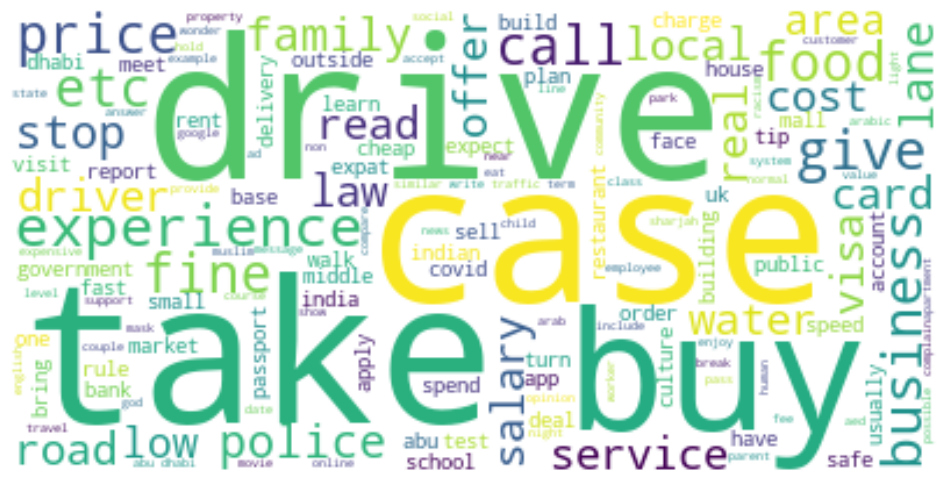

In [81]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(bigram_features, X_bigram.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

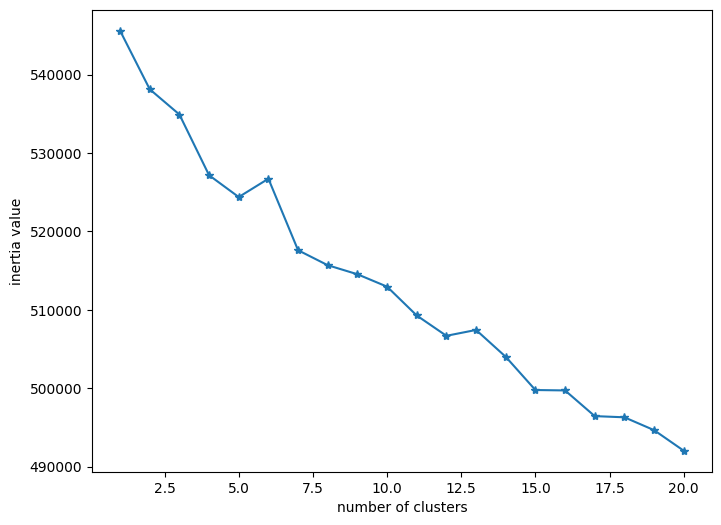

In [82]:
#determine optimum k-clusters
sse_metric = []
k_range = list(range(1,21))
sil_score = {}

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10)#, batch_size = 5000)
    kmeans.fit(X_bigram)
    sse_metric.append(kmeans.inertia_)
    
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

plt.show()

In [ ]:
#calculate silhouette scores for each k-cluster
for k in k_range:
    if k > 1:
        score = silhouette_score(X_ngram, kmeans.labels_)
        sil_score.update({f'{k} clusters':score})
    